## 0. 목차

1. 베이스 모델 구현   
    1) set-up   
    2) 데이터 가져오기   
    3) 데이터 시각화   
    4) CNN 모델링   
    5) 데이터 imbalance 처리   
    6) 모델 훈련   
    7) 결과 확인과 시각화   
    8) 결과 분석    
    
2. 모델 성능 개선 - augmentation    
    1) 하이퍼 파라미터 set-up   
    2) 데이터 준비 - augmentation   
    3) 데이터 시각화   
    4) 모델 훈련   
    5) 결과 확인   
    6) 결과 분석   

    
 3. 모델 성능 개선 - ResNet + Augmentation + 데이터 imbalance 처리    
    1) ResNet-18 구현   
    2) 데이터 imbalance 처리   
    3) 모델 훈련   
    4) 결과 확인   
    5) 결과 분석   
   
4. 결론 및 회고   

## 1. 베이스 모델 구현

### 1) set-up

In [2]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


### 2) 데이터 가져오기

In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 3) 데이터 시각화

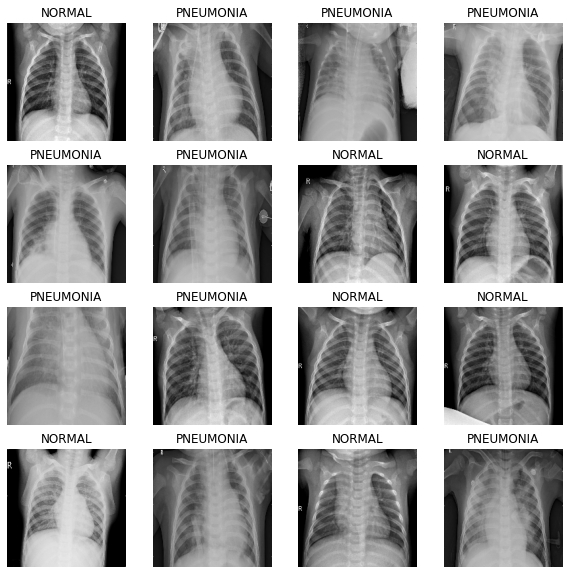

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### 4) CNN 모델링

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 5) 데이터 imbalance 처리

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


### 6) 모델 훈련

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [23]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 71s 204ms/step - loss: 0.1122 - accuracy: 0.9562 - precision: 0.9886 - recall: 0.9520 - val_loss: 0.3840 - val_accuracy: 0.8644 - val_precision: 1.0000 - val_recall: 0.8157
Epoch 2/10
261/261 [==============================] - 53s 202ms/step - loss: 0.1124 - accuracy: 0.9579 - precision: 0.9874 - recall: 0.9556 - val_loss: 0.1234 - val_accuracy: 0.9577 - val_precision: 0.9918 - val_recall: 0.9503
Epoch 3/10
261/261 [==============================] - 53s 204ms/step - loss: 0.1052 - accuracy: 0.9634 - precision: 0.9904 - recall: 0.9601 - val_loss: 0.2732 - val_accuracy: 0.8885 - val_precision: 1.0000 - val_recall: 0.8484
Epoch 4/10
261/261 [==============================] - 53s 205ms/step - loss: 0.1167 - accuracy: 0.9571 - precision: 0.9880 - recall: 0.9539 - val_loss: 0.2705 - val_accuracy: 0.8837 - val_precision: 0.9969 - val_recall: 0.8442
Epoch 5/10
261/261 [==============================] - 55s 211ms/step - loss: 0.1067 - accura

### 7) 결과 확인

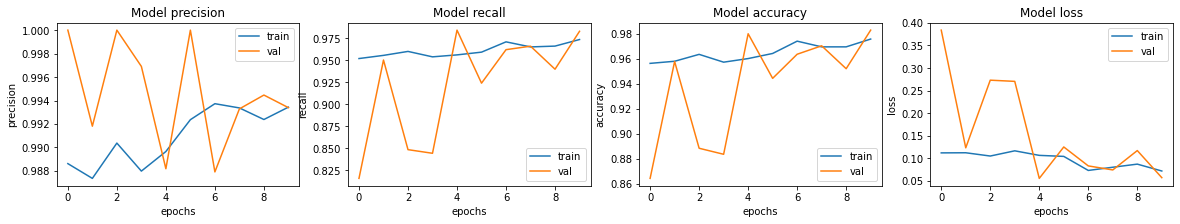

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [27]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 118ms/step - loss: 0.9216 - accuracy: 0.8077 - precision: 0.7668 - recall: 0.9949
Loss: 0.921574592590332,
Accuracy: 0.807692289352417,
Precision: 0.7667984366416931,
Recall: 0.9948717951774597


### 8) 결과 분석
    - Recall 값은 높으나, Precision 값이 낮음.
        -> 정상을 폐렴으로 과하게 예측할 수 있음
    - Precision, Accuracy의 훈련 및 검증값 대비 test 값이 많이 떨어져있음.
        -> 과적합 가능성 있음

## 2. 모델 성능 개선 - augmentation

### 1) set-up

In [28]:
BATCH_SIZE = 16
EPOCHS = 15

### 2) 데이터 준비 - augmentation

In [34]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 3) 데이터 시각화

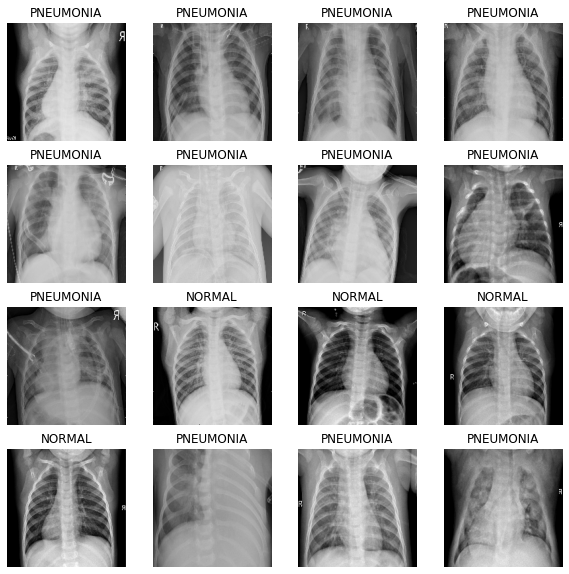

In [35]:
# 좌우 반전 확인
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### 4) 모델 훈련

In [59]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [60]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
261/261 [==============================] - 62s 202ms/step - loss: 0.4694 - accuracy: 0.8321 - precision: 0.9486 - recall: 0.8189 - val_loss: 0.7960 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/15
261/261 [==============================] - 52s 200ms/step - loss: 0.2902 - accuracy: 0.9203 - precision: 0.9660 - recall: 0.9253 - val_loss: 1.4352 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/15
261/261 [==============================] - 52s 200ms/step - loss: 0.2794 - accuracy: 0.9217 - precision: 0.9652 - recall: 0.9282 - val_loss: 0.3155 - val_accuracy: 0.8721 - val_precision: 0.8519 - val_recall: 1.0000
Epoch 4/15
261/261 [==============================] - 52s 201ms/step - loss: 0.2375 - accuracy: 0.9330 - precision: 0.9707 - recall: 0.9381 - val_loss: 0.1250 - val_accuracy: 0.9471 - val_precision: 0.9383 - val_recall: 0.9935
Epoch 5/15
261/261 [==============================] - 53s 202ms/step - loss: 0.2221 - accura

### 5) 결과 확인

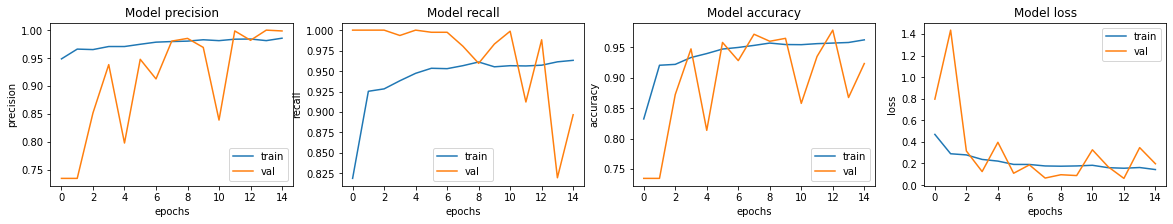

In [61]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [62]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 111ms/step - loss: 0.4651 - accuracy: 0.8429 - precision: 0.8333 - recall: 0.9359
Loss: 0.4651460349559784,
Accuracy: 0.8429487347602844,
Precision: 0.8333333134651184,
Recall: 0.9358974099159241


### 6) 결과 분석
    - 변경 내용: data random augmentation 적용 + batch size 증가 (10 -> 15)
    - 베이스라인 모델에 비해 아래와 같은 양상을 보이며, 전반적으로 향상된 성능을 보였음
        - loss 크게 감소
        - accuracy 증가
        - precision 증가
        - recall 감소 (균형 조정)
    - Precision, Accuracy의 훈련 및 검증값 대비 test 값 차이가 소폭 감소하였음
        -> 과적합 가능성은 개선되었으나, 완벽히 해소되었다고 보기는 어려움

## 3. 모델 성능 개선 - ResNet + Augmentation + 데이터 imbalance 처리

### 1) ResNet-18 구현

In [38]:
from tensorflow.keras import layers, models

# Residual block 구성
def residual_block(x, filters):
    identity = x  # Skip Connection

    # 첫 번째 3x3 Conv Layer + ReLU
    x = layers.Conv2D(filters, (3, 3), padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 두 번째 3x3 Conv Layer + Skip Connection + relu
    x = layers.Conv2D(filters, (3, 3), padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    
    # identity의 채널 수가 다를 경우 1*1 conv 적용
    if identity.shape[-1] != filters:
        identity = layers.Conv2D(filters, (1, 1), padding="same", kernel_initializer="he_normal")(identity)

    x = layers.Add()([x, identity])  # Skip Connection
    x = layers.ReLU()(x)

    return x

In [54]:
# ResNet-18 모델 구현
def build_resnet(input_shape, filters):
    inputs = layers.Input(shape=input_shape)

    # conv1: 7x7, stride 2
    x = layers.Conv2D(filters[0], (7, 7), strides=2, padding="same", kernel_initializer="he_normal")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # conv2_x
    x = layers.MaxPooling2D((3, 3), strides=2, padding="same")(x) # max pool
    for _ in range(2):
        x = residual_block(x, filters[0])

    # conv3_x
    for _ in range(2):
        x = residual_block(x, filters[1])

    # conv4_x
    for _ in range(2):
        x = residual_block(x, filters[2])

    # conv5_x
    for _ in range(2):
        x = residual_block(x, filters[3])

    # Average Pooling & Fully Connected Layer
    x = layers.AveragePooling2D(pool_size=(7,7))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs, x)
    return model

# 모델 생성 및 요약
model = build_resnet(input_shape=(180, 180, 3), filters=[32, 64, 128, 256])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_93 (Conv2D)              (None, 90, 90, 32)   4736        input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_96 (BatchNo (None, 90, 90, 32)   128         conv2d_93[0][0]                  
__________________________________________________________________________________________________
re_lu_74 (ReLU)                 (None, 90, 90, 32)   0           batch_normalization_96[0][0]     
____________________________________________________________________________________________

### 2) 데이터 imbalance 처리

In [42]:
class_weight = {0: weight_for_0, 1: weight_for_1 * 1.5}  # 폐렴에 1.5배 강조

### 3) 모델 훈련

In [64]:
with tf.device('/GPU:0'):
    model = model
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [65]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
261/261 [==============================] - 62s 202ms/step - loss: 0.1485 - accuracy: 0.9622 - precision: 0.9855 - recall: 0.9633 - val_loss: 0.1640 - val_accuracy: 0.9413 - val_precision: 0.9282 - val_recall: 0.9974
Epoch 2/15
261/261 [==============================] - 51s 197ms/step - loss: 0.1624 - accuracy: 0.9550 - precision: 0.9818 - recall: 0.9572 - val_loss: 0.0859 - val_accuracy: 0.9567 - val_precision: 0.9701 - val_recall: 0.9714
Epoch 3/15
261/261 [==============================] - 52s 201ms/step - loss: 0.1358 - accuracy: 0.9629 - precision: 0.9868 - recall: 0.9630 - val_loss: 0.0974 - val_accuracy: 0.9721 - val_precision: 0.9683 - val_recall: 0.9948
Epoch 4/15
261/261 [==============================] - 53s 203ms/step - loss: 0.1368 - accuracy: 0.9634 - precision: 0.9865 - recall: 0.9639 - val_loss: 0.0767 - val_accuracy: 0.9644 - val_precision: 0.9853 - val_recall: 0.9659
Epoch 5/15
261/261 [==============================] - 53s 203ms/step - loss: 0.1261 - accura

### 7) 결과 확인과 시각화

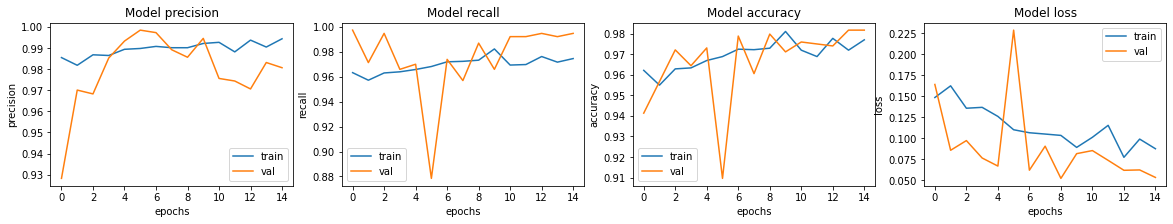

In [66]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [67]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 119ms/step - loss: 1.6435 - accuracy: 0.7260 - precision: 0.6952 - recall: 1.0000
Loss: 1.6434729099273682,
Accuracy: 0.7259615659713745,
Precision: 0.6951871514320374,
Recall: 1.0


### 8) 결과 분석
    - 변경 내용: ResNet-18 모델 적용 + 데이터 imbalance 처리(recall 값 개선을 위해 폐렴에 1.5배 강조)
    - 폐렴을 100% 검출하는 대신, 전반적인 성능이 저하되는 방향으로 변화하였음 
        - loss 급증
        - accuracy 하락
        - precision 급락
        - recall 증가 (100%)
    - recall 값이 과도해진 것은 class weight 조정이 과도했다고 해석될 수 있음.

## 4. 결론 및 회고

1) 실험 별 주요 변화점 분석

    A. 베이스라인 모델
        a. 장점:
            - 기본적인 성능 확보 (Accuracy 0.81, Recall 0.99)
            - 폐렴을 놓치지 않는(Recall 높음) 모델
        b. 단점:
            - 과적합 발생 → Train과 Validation 차이가 큼
            - Precision 낮음(0.77) → False Positive 증가 가능성
            - Loss가 0.92로 높음 → Confidence 부족
            
    B. 첫번째 실험
        a. 개선점:
            - Augmentation 적용 → 데이터 다양성 증가, 일반화 성능 개선
            - Batch Size 증가 (10→15) → 학습 안정성 증가
            - Loss 급감 (0.92 → 0.46) → 모델이 안정적으로 학습됨
            - Precision 증가 (0.77 → 0.83), Recall 균형 조정 (0.99 → 0.94)
        b. 결론:
            - Precision과 Recall 균형을 맞추면서 가장 이상적인 모델 성능을 기록
            - 과적합이 줄어들고 일반화 성능이 증가함.
            - 실험 중 가장 좋은 결과
    
    C. 두번째 실험
        a. 변경 사항:
            - ResNet-18 적용 → 더 깊은 모델 사용
            - 폐렴 데이터 1.5배 강조 (Class Weight 조정) → Recall 극대화
        b. 문제점:
            - Recall이 1.00으로 극단적으로 높아짐 → 폐렴을 100% 탐지하지만, Precision이 급락(0.69)
            - Loss 증가 (0.46 → 1.64) → Confidence 부족, 모델 신뢰도 하락
            - Accuracy 감소 (0.84 → 0.73) → 모델 성능 저하
            - Precision 급락 (0.83 → 0.69) → 정상 데이터를 폐렴으로 오진하는 문제 심화
        c. 결론:
            - Precision을 희생하면서 Recall을 극단적으로 높인 실패한 실험.
            - Loss 증가(1.64)로 인해 모델이 과적합되었거나, Confidence를 제대로 형성하지 못했음.
            - ResNet-18을 도입했지만, 폐렴 강조를 지나치게 하여 성능이 악화됨.
            
2) 향후 개선 방향:   
    - 과도한 recall 중시를 완화하기 위한 Class Weight 조정   
    - 과적합 방지를 위한 regularization 적용   